 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/feature_importance.ipynb#Get-data" data-toc-modified-id="Get-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/feature_importance.ipynb#Build-a-neural-net-with-only-one-output" data-toc-modified-id="Build-a-neural-net-with-only-one-output-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build a neural net with only one output</a></span></li><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/feature_importance.ipynb#BOOOOOST" data-toc-modified-id="BOOOOOST-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>BOOOOOST</a></span></li><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/feature_importance.ipynb#CRPS-objective-function-for-XGBoost" data-toc-modified-id="CRPS-objective-function-for-XGBoost-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CRPS objective function for XGBoost</a></span></li></ul></div>

# XGBoost 

## Get data

As usual.

In [1]:
from importlib import reload
import utils; reload(utils)
from utils import *
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Dropout
from keras.layers.merge import Concatenate
from keras.models import Model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from crps_loss import crps_cost_function

Using Theano backend.


In [2]:
# Basic setup
DATA_DIR = '/Volumes/STICK/data/ppnn_data/'  # Mac
# DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # LMU
results_dir = '../results/'

In [3]:
aux_dict = OrderedDict()
aux_dict['data_aux_geo_interpolated.nc'] = ['orog', 
                                            'station_alt', 
                                            'station_lat', 
                                            'station_lon']
aux_dict['data_aux_pl500_interpolated_00UTC.nc'] = ['u_pl500_fc',
                                                    'v_pl500_fc',
                                                    'gh_pl500_fc']
aux_dict['data_aux_pl850_interpolated_00UTC.nc'] = ['u_pl850_fc',
                                                    'v_pl850_fc',
                                                    'q_pl850_fc']
aux_dict['data_aux_surface_interpolated_00UTC.nc'] = ['cape_fc',
                                                      'sp_fc',
                                                      'tcc_fc']

In [4]:
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates,
                                          aux_dict=aux_dict)

train set contains 365 days
test set contains 366 days


## Build a neural net with only one output

In [5]:
def build_hidden_model(hidden_nodes, feature_size=2, out_size=1):
    inp = Input(shape=(feature_size,))
    x = Dense(hidden_nodes, activation='relu')(inp)
    x = Dense(out_size, activation='linear')(x)
    return Model(inputs=inp, outputs=x)

In [6]:
hidden_model = build_hidden_model(50, train_set.features.shape[1], 1)

In [7]:
hidden_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1250      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [8]:
hidden_model.compile(optimizer=Adam(0.001), loss='mse')

In [12]:
hidden_model.fit(train_set.features, train_set.targets, epochs=10, batch_size=1024,
             validation_data=[test_set.features, test_set.targets])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 0s - loss: 3.1179 - val_loss: 3.0431
Epoch 2/10
180849/180849 [==============================] - 0s - loss: 3.1144 - val_loss: 3.0329
Epoch 3/10
180849/180849 [==============================] - 0s - loss: 3.1122 - val_loss: 3.0200
Epoch 4/10
180849/180849 [==============================] - 0s - loss: 3.1124 - val_loss: 3.0128
Epoch 5/10
180849/180849 [==============================] - 0s - loss: 3.1065 - val_loss: 3.0284
Epoch 6/10
180849/180849 [==============================] - 0s - loss: 3.1107 - val_loss: 3.0086
Epoch 7/10
180849/180849 [==============================] - 0s - loss: 3.1036 - val_loss: 3.0295
Epoch 8/10
180849/180849 [==============================] - 0s - loss: 3.1004 - val_loss: 3.0848
Epoch 9/10
180849/180849 [==============================] - 0s - loss: 3.0990 - val_loss: 3.0544
Epoch 10/10
180849/180849 [==============================] - 0s - loss: 3.0

In [13]:
np.sqrt(hidden_model.evaluate(test_set.features, test_set.targets))

174528/182218 [===========================>..] - ETA: 0s

1.7506607542837958

In [14]:
def build_linear_model(feature_size=2, out_size=1):
    inp = Input(shape=(feature_size,))
    x = Dense(out_size, activation='linear')(inp)
    return Model(inputs=inp, outputs=x)

In [15]:
linear_model = build_linear_model(train_set.features.shape[1], 1)

In [16]:
linear_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [17]:
linear_model.compile(optimizer=Adam(0.01), loss='mse')

In [23]:
linear_model.fit(train_set.features, train_set.targets, epochs=10, batch_size=1024,
             validation_data=[test_set.features, test_set.targets])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 0s - loss: 3.2332 - val_loss: 3.0629
Epoch 2/10
180849/180849 [==============================] - 0s - loss: 3.2321 - val_loss: 3.0679
Epoch 3/10
180849/180849 [==============================] - 0s - loss: 3.2323 - val_loss: 3.0533
Epoch 4/10
180849/180849 [==============================] - 0s - loss: 3.2319 - val_loss: 3.0630
Epoch 5/10
180849/180849 [==============================] - 0s - loss: 3.2315 - val_loss: 3.0760
Epoch 6/10
180849/180849 [==============================] - 0s - loss: 3.2320 - val_loss: 3.0539
Epoch 7/10
180849/180849 [==============================] - 0s - loss: 3.2317 - val_loss: 3.0487
Epoch 8/10
180849/180849 [==============================] - 0s - loss: 3.2318 - val_loss: 3.0560
Epoch 9/10
180849/180849 [==============================] - 0s - loss: 3.2316 - val_loss: 3.0580
Epoch 10/10
180849/180849 [==============================] - 0s - loss: 3.2

In [24]:
w = linear_model.layers[1].get_weights()[0]

In [25]:
w.shape

(24, 1)

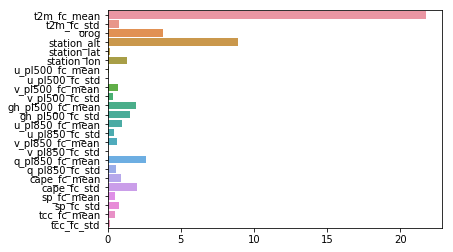

In [26]:
sns.barplot(y=train_set.feature_names, x=np.abs(w[:, 0]))

In [27]:
linear_model = build_linear_model(train_set.features.shape[1], 2)
linear_model.compile(optimizer=Adam(0.01), loss=crps_cost_function)

In [31]:
linear_model.fit(train_set.features, train_set.targets, epochs=10, batch_size=1024,
             validation_data=[test_set.features, test_set.targets])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 0s - loss: 0.9751 - val_loss: 0.9555
Epoch 2/10
180849/180849 [==============================] - 0s - loss: 0.9738 - val_loss: 0.9508
Epoch 3/10
180849/180849 [==============================] - 0s - loss: 0.9728 - val_loss: 0.9496
Epoch 4/10
180849/180849 [==============================] - 0s - loss: 0.9723 - val_loss: 0.9471
Epoch 5/10
180849/180849 [==============================] - 0s - loss: 0.9716 - val_loss: 0.9515
Epoch 6/10
180849/180849 [==============================] - 0s - loss: 0.9713 - val_loss: 0.9435
Epoch 7/10
180849/180849 [==============================] - 0s - loss: 0.9711 - val_loss: 0.9444ss: 0
Epoch 8/10
180849/180849 [==============================] - 0s - loss: 0.9707 - val_loss: 0.9439
Epoch 9/10
180849/180849 [==============================] - 0s - loss: 0.9705 - val_loss: 0.9425
Epoch 10/10
180849/180849 [==============================] - 0s - loss

In [36]:
preds = linear_model.predict(test_set.features)
results_df = create_results_df(test_set.date_strs, test_set.station_ids,
                               preds[:, 0], preds[:, 1])
results_df.to_csv(results_dir + 'fc_network_aux_train_2015_pred_2016.csv')

In [32]:
w = linear_model.layers[1].get_weights()[0]
w.shape

(24, 2)

In [33]:
w

array([[ 21.55556107,  -0.70024198],
       [ -0.7106874 ,  -2.65330625],
       [  3.9828589 ,  -0.43749264],
       [-10.15917397,  -1.56758964],
       [ -0.55702108,   0.18167441],
       [ -1.12517023,  -0.26317564],
       [  0.18476054,  -0.13982216],
       [ -0.07289345,   0.68600416],
       [ -0.71506745,   0.07589541],
       [  0.46722719,   0.60490781],
       [  1.52971852,  -1.34756672],
       [ -1.14905655,   0.4754779 ],
       [  0.87684828,   0.14090069],
       [  0.43111378,  -0.75561202],
       [  0.49245536,  -0.56652683],
       [ -0.05685833,   0.14790827],
       [  3.03324747,   1.41057789],
       [  0.56196392,  -0.11340396],
       [ -0.41695151,   0.07533995],
       [  1.43556952,  -0.47592199],
       [ -0.12202962,  -0.23491184],
       [  0.24239618,   0.16700497],
       [  0.54675311,   0.60206783],
       [  0.27723232,  -0.11335158]], dtype=float32)

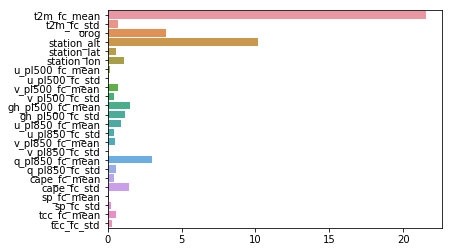

In [34]:
sns.barplot(y=train_set.feature_names, x=np.abs(w[:, 0]))

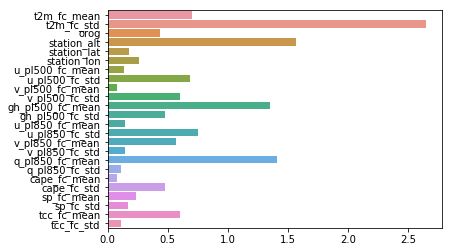

In [35]:
sns.barplot(y=train_set.feature_names, x=np.abs(w[:, 1]))

## BOOOOOST

In [18]:
import xgboost as xgb

/Users/stephanrasp/anaconda/envs/py36_keras/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [48]:
dtrain = xgb.DMatrix(train_set.features, train_set.targets, 
                     feature_names=train_set.feature_names)
dtest = xgb.DMatrix(test_set.features, test_set.targets, 
                     feature_names=test_set.feature_names)

In [51]:
our_params={
            'eta':0.3,
            'subsample':0.8,
            'objective':'reg:linear',
            'eval_metric': 'rmse',
            }
watchlist  = [(dtest,'eval'), (dtrain,'train')]

In [56]:
bst=xgb.train(our_params, dtrain, 30, watchlist)

[0]	eval-rmse:6.91028	train-rmse:6.92588
[1]	eval-rmse:5.02271	train-rmse:5.02794
[2]	eval-rmse:3.76052	train-rmse:3.75562
[3]	eval-rmse:2.94882	train-rmse:2.92686
[4]	eval-rmse:2.44828	train-rmse:2.40732
[5]	eval-rmse:2.14258	train-rmse:2.09606
[6]	eval-rmse:1.97091	train-rmse:1.91422
[7]	eval-rmse:1.87266	train-rmse:1.80578
[8]	eval-rmse:1.82303	train-rmse:1.74007
[9]	eval-rmse:1.79319	train-rmse:1.69971
[10]	eval-rmse:1.77206	train-rmse:1.66983
[11]	eval-rmse:1.76417	train-rmse:1.65135
[12]	eval-rmse:1.75511	train-rmse:1.63448
[13]	eval-rmse:1.75209	train-rmse:1.62086
[14]	eval-rmse:1.74149	train-rmse:1.60532
[15]	eval-rmse:1.7372	train-rmse:1.59292
[16]	eval-rmse:1.73616	train-rmse:1.58469
[17]	eval-rmse:1.7337	train-rmse:1.57744
[18]	eval-rmse:1.73108	train-rmse:1.5722
[19]	eval-rmse:1.73003	train-rmse:1.56726
[20]	eval-rmse:1.73132	train-rmse:1.55851
[21]	eval-rmse:1.72977	train-rmse:1.55354
[22]	eval-rmse:1.72867	train-rmse:1.54978
[23]	eval-rmse:1.72383	train-rmse:1.53983
[24]	

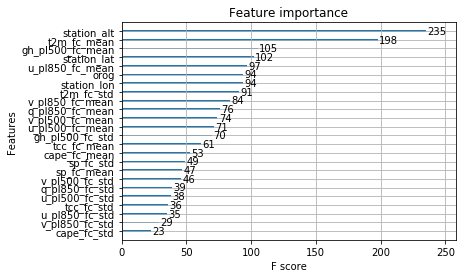

In [57]:
xgb.plot_importance(bst)

## CRPS objective function for XGBoost

In [58]:
# Doesn't work I think unless I do the binning stuff...